![Banner](../img/banner/banner.png)


# 03 - Modelado Base

## Descripción
Este notebook tiene como objetivo realizar una carga inicial de los datos, estructurarlos (especialmente datos anidados en formato JSON), y realizar un análisis exploratorio rápido utilizando `pandas-profiling`. Además, se documentarán observaciones y hallazgos simples, y se proporcionará un resumen con los siguientes pasos planeados

In [ ]:
import torch
print(torch.cuda.is_available())  # True si la GPU está activa
print(torch.cuda.get_device_name(0))  # Modelo de la GPU

True
Tesla T4


# 1 - Dependencias:

### 1.1 Instalación de dependencias

In [1]:
# NPL Clasic
!pip install spacy
# Transformer
!pip install sentence_transformers
!pip install faiss-cpu
#python -m spacy download es_core_news_lg # model large
!python -m spacy download es_core_news_sm # model small
!pip install swifter
!pip install rapidfuzz
!pip install optuna
!pip install embedding_encoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 26.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### 1.2 Importación de dependencias

In [125]:
# Complementos
import warnings
from pathlib import Path
import gc
import requests

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-procesamiento
from typing import List
import re
import json
import ast
import pandas as pd
import numpy as np
from dateutil.parser import parse
from sklearn.impute import KNNImputer
import unicodedata
from rapidfuzz import process, fuzz
import swifter  # Para paralelización rápida

import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
from scipy.stats.mstats import winsorize

# NPL Clasic
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from collections import Counter

# Transformers
import faiss
import torch
from sentence_transformers import SentenceTransformer

# Modelos
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from embedding_encoder import EmbeddingEncoder
from embedding_encoder.utils.compose import ColumnTransformerWithNames
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

import optuna
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from optuna.visualization import plot_optimization_history, plot_param_importances

from sklearn.metrics import roc_curve, auc

In [3]:
import sklearn
print(sklearn.__version__)

1.2.2


In [ ]:
import sys
print(sys.version)

In [ ]:
!python --version

In [6]:
#!pip install scikit-learn==1.2.2

In [ ]:
import sklearn
print(sklearn.__version__)

### 1.3 Conexión a Datasets desde Google Drive

In [20]:
from google.colab import files
from google.colab import drive

### 1.4 Constantes

In [21]:
categorias_MELI = [
        "Accesorios para Vehículos", "Agro", "Alimentos y Bebidas", "Animales y Mascotas", "Antiguedades y Colecciones",
        "Arte, Papelería y Mercería", "Bebés", "Belleza y Cuidado Personal", "Boletas para Espectáculos",
        "Cámaras y Accesorios", "Carros, Motos y Otros", "Celulares y Teléfonos", "Computación",
        "Consolas y Videojuegos", "Construcción", "Deportes y Fitness", "Electrodomésticos",
        "Electrónica, Audio y Video", "Herramientas", "Hogar y Muebles", "Industrias y Oficinas",
        "Inmuebles", "Instrumentos Musicales", "Juegos y Juguetes", "Libros, Revistas y Comics",
        "Música, Películas y Series", "Recuerdos, Piñatería y Fiestas", "Relojes y Joyas",
        "Ropa y Accesorios", "Salud y Equipamiento Médico", "Servicios", "Otras categorías"
    ]

url = "https://apis.datos.gob.ar/georef/api/municipios?max=5000"

feature_engineering = ['warranty_class', 'pictures_area', 'pictures_max_area', 'pictures_ratio_relation', 'pictures_max_ratio_relation',
 'diff_price', 'time_since_last_update', 'title_class', 'categoria_predicha', 'len_title', 'seller_address_state.name_clean_match',
 'seller_address_city.name_clean_match']

feature = ['base_price', 'shipping_local_pick_up', 'shipping_free_shipping',
       'shipping_mode', 'non_mercado_pago_payment_methods_description',
       'non_mercado_pago_payment_methods_type', 'listing_type_id', 'price',
       'buying_mode', 'tags_0', 'accepts_mercadopago', 'automatic_relist',
       'status', 'initial_quantity', 'sold_quantity', 'available_quantity',
           'have_warranty', 'pictures_width', 'pictures_height',
       'pictures_max_width', 'pictures_max_height','time_to_start',
       'listing_duration', 'category_id', 'seller_id'
]
target = ['condition']

selected_features = ['pictures_max_width', 'title_class', 'sold_quantity', 'pictures_width', 'listing_type_id',
                     'pictures_max_height', 'pictures_max_area', 'pictures_area', 'initial_quantity', 'pictures_height',
                     'shipping_mode', 'non_mercado_pago_payment_methods_description', 'seller_address_state.name_clean_match',
                     'diff_price', 'category_id', 'price', 'seller_address_city.name_clean_match', 'len_title', 'listing_duration',
                     'seller_id', 'time_since_last_update', 'categoria_predicha', 'warranty_class', 'pictures_max_ratio_relation',
                     'base_price', 'available_quantity']

# 2 - Funciones:

### 2.1 Funciones de carga datasets

In [7]:
def build_dataset(path):
    data = [json.loads(x) for x in open(path)]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

### 2.2 Funciones de NPL Clasicas

In [8]:
# nltk.download('stopwords')
# nltk.download('punkt')

# nlp_es = spacy.load("es_core_news_sm")
# nlp_en = spacy.load("en_core_web_sm")

# def remove_stopwords(text: str, language: str = 'spanish', keep_words: List[str] = []) -> str:
#     """
#       Elimina stopwords del texto en el idioma seleccionado, excluye palabras clave.

#       Args:
#           text (str): Texto de entrada.
#           language (str): Idioma de las stopwords ('spanish', 'english', etc.).
#           keep_words (List[str]): Lista de palabras que no deben ser eliminadas.

#       Returns:
#           str: Texto sin stopwords.
#     """
#     stop_words = set(stopwords.words(language))
#     stop_words.difference_update(keep_words)  # Asegura que las palabras en keep_words no sean eliminadas
#     return ' '.join([word for word in text.split() if word.lower() not in stop_words])

In [9]:
nltk.download('stopwords')
nltk.download('punkt')

nlp_es = spacy.load("es_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

def remove_stopwords(text, language='spanish', keep_words=[]):
    """Elimina stopwords del texto en español o inglés, excepto términos clave."""
    stop_words = set(stopwords.words(language))
    stop_words.difference_update(keep_words)  # Asegura que las palabras en keep_words no sean eliminadas
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

def lemmatize_text(text, language='spanish'):
    """Aplica lematización al texto en español o inglés."""
    nlp = nlp_es if language == 'spanish' else nlp_en
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def stem_text(text, language='spanish'):
    """Aplica stemming al texto en español o inglés."""
    stemmer = SnowballStemmer(language)
    return ' '.join([stemmer.stem(word) for word in text.split()])

import unicodedata
def clean_text_regex(text):
    """Limpia texto eliminando caracteres especiales, quitando tildes y convirtiendo 'ñ' en 'n'."""
    text = re.sub(r'http\S+|www\S+', '', text)  # Elimina URLs
    text = re.sub(r'[^\w\s]', '', text)  # Elimina signos de puntuación
    text = re.sub(r'\s+', ' ', text).strip()  # Reduce múltiples espacios
    #text = re.sub(r'\d+', '', text)  # Elimina números
    text = ''.join(char.lower() if char.isalpha() or char.isdigit() else char for char in text)  # Convierte letras a minúsculas

    # Normaliza el texto para eliminar tildes y cambiar 'ñ' por 'n'
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = text.replace('ñ', 'n')  # Reemplaza 'ñ' por 'n'

    return text

def clean_text(text, remove_sw=True, lemmatize=True, stem=False, use_regex=True, language='spanish' ,keep_words=[]):
    """Aplica las funciones de limpieza de texto según los parámetros proporcionados."""
    if use_regex:
        text = clean_text_regex(text)
    if remove_sw:
        text = remove_stopwords(text, language, keep_words)
    if lemmatize:
        text = lemmatize_text(text, language)
        text = clean_text_regex(text)
        text = remove_stopwords(text, language, keep_words)
    if stem:
        text = stem_text(text, language)
    return text

def wordcloud_custom(df_temp, col ,num_words=30):
    all_words = " ".join(df_temp[col]).split()
    word_counts = Counter(all_words)

    top_words = word_counts.most_common(num_words)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Nube de palabras")

    plt.subplot(2, 1, 2)
    plt.barh([word[0] for word in reversed(top_words)], [word[1] for word in reversed(top_words)], color="royalblue")
    plt.xlabel("Frecuencia")
    plt.title("Palabras más frecuentes")

    plt.tight_layout()
    plt.show()

    return

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 2.3 Funciones de Transformers

In [10]:
def load_model(model_name="paraphrase-multilingual-MiniLM-L12-v2"):
    """Carga el modelo de embeddings optimizado para español."""
    model = SentenceTransformer(model_name)
    return model


def generate_embeddings(text_list, model, batch_size=100):
    """Genera embeddings para una lista de textos usando SentenceTransformer."""
    return model.encode(text_list, batch_size=batch_size, convert_to_numpy=True)


def create_faiss_index(embeddings):
    """Crea un índice FAISS para búsqueda eficiente con similitud coseno."""
    index = faiss.IndexFlatIP(embeddings.shape[1])  # Índice de producto interno
    faiss.normalize_L2(embeddings)  # Normalizar para similitud coseno
    index.add(embeddings)
    return index


def categorize_products(df, model, categorias, batch_size=100):
    """Genera embeddings de productos, los compara con las categorías y asigna la más similar."""

    # Obtener embeddings de productos
    print("Generando embeddings de productos...")
    product_embeddings = generate_embeddings(df["title_clean"].tolist(), model, batch_size)

    # Obtener embeddings de categorías
    print("Generando embeddings de categorías...")
    category_embeddings = generate_embeddings(categorias, model)

    # Crear índice FAISS
    print("Creando índice FAISS...")
    index = create_faiss_index(category_embeddings)

    # Normalizar embeddings de productos para similitud coseno
    faiss.normalize_L2(product_embeddings)

    # Buscar la categoría más cercana para cada producto
    print("Buscando la categoría más similar...")
    _, closest_categories = index.search(product_embeddings, 1)

    # Asignar categorías al dataframe
    df["categoria_predicha"] = [categorias[i] for i in closest_categories.flatten()]

    return df


def save_results(df, filename):
    """Guarda los resultados en un archivo CSV."""
    df.to_csv(filename, index=False, sep='|')
    print(f"Resultados guardados en {filename}")

### 2.4 Funciones pre process

In [11]:
def clean_data_init(df: pd.DataFrame) -> pd.DataFrame:
    """
    Limpia un df de pandas, eliminando estructuras anidadas,
    columnas irrelevantes y optimizando tipos de datos.

    Args:
        df (pd.DataFrame): df original a limpiar.
        path (str): Directorio donde se guardará el reporte de pandas-profiling.
        file_name (str): Nombre del archivo para el reporte HTML.

    Returns:
        Tuple[pd.DataFrame, ProfileReport]: df limpio y reporte de perfilado.
    """

    print("Aplicando transformación de estructuras anidadas...")
    def flatten_json(value, prefix=''):
        # Convierte estructuras anidadas ej. 'JSON, listas' en columnas planas
        if isinstance(value, str):
            try:
                value = ast.literal_eval(value)
            except (ValueError, SyntaxError):
                return {prefix: value}

        if isinstance(value, dict):
            return {f'{prefix}_{k}': v for k, v in value.items()} or {prefix: np.nan}

        if isinstance(value, list):
            if not value:
                return {prefix: np.nan}
            elif all(isinstance(i, dict) for i in value):
                return {f'{prefix}_{k}': v for item in value for k, v in item.items()}
            return {f'{prefix}_{i}': v for i, v in enumerate(value)}

        return {prefix: value}

    # Aplica transformacion
    print("Eliminando columnas irrelevantes...")
    df_expanded = pd.concat(
        [pd.json_normalize(df[col].apply(lambda x: flatten_json(x, col))) for col in df.columns],
        axis=1
    )

    # Elimina columnas con 'id', 'url' o 'permalink'
    df_expanded.columns = df_expanded.columns.astype(str)
    df_clean = df_expanded.loc[:, ~df_expanded.columns.str.contains(r'\b(url|permalink)\b', case=False, regex=True)]

    # Convierte tipos de datos validando fechas
    print("Validando columnas de fecha...")
    for col in df_clean.select_dtypes(include=['object']):
        try:
            sample_values = df_clean[col].dropna().sample(n=min(10, len(df_clean[col].dropna())), random_state=42).tolist()
            if all(isinstance(parse(val, fuzzy=True), pd.Timestamp) for val in sample_values):
                df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce', infer_datetime_format=True)
        except Exception:
            continue

    # Convierte columnas especificas a tipos adecuados
    if 'warranty' in df_clean.columns:
        df_clean['warranty'] = df_clean['warranty'].astype('string')

    df_clean.reset_index(inplace=True)

    print("Extrayendo dimensiones de imágenes...")
    def extract_dimensions(size):
        """Extrae el ancho y alto de una cadena con formato 'AnchoxAlto'."""
        if isinstance(size, str) and 'x' in size:
            width, height = map(int, size.split('x'))
            return width, height
        return None, None

    # alto y ancho de cada imagen
    df_clean[['pictures_width', 'pictures_height']] = df_clean['pictures_size'].apply(lambda x: pd.Series(extract_dimensions(x)))
    df_clean[['pictures_max_width', 'pictures_max_height']] = df_clean['pictures_max_size'].apply(lambda x: pd.Series(extract_dimensions(x)))

    df_clean['date_created'] = pd.to_datetime(df_clean['date_created'], utc=True)
    df_clean['last_updated'] = pd.to_datetime(df_clean['last_updated'], utc=True)

    df_clean['start_time'] = pd.to_datetime(df_clean['start_time'], unit='ms', utc=True)
    df_clean['stop_time'] = pd.to_datetime(df_clean['stop_time'], unit='ms', utc=True)

    df_clean = df_clean[['seller_address_state.name', 'seller_address_city.name', 'condition',
       'base_price', 'shipping_local_pick_up', 'shipping_free_shipping',
       'shipping_mode', 'non_mercado_pago_payment_methods_description',
       'non_mercado_pago_payment_methods_type', 'listing_type_id', 'price',
       'buying_mode', 'tags_0', 'accepts_mercadopago', 'automatic_relist',
       'status', 'initial_quantity', 'sold_quantity', 'available_quantity',
       'warranty', 'pictures_width', 'pictures_height', 'pictures_max_width',
        'pictures_max_height', 'start_time', 'stop_time',
        'date_created', 'last_updated', 'title', 'seller_id', 'category_id']]

    return df_clean.reset_index(drop=True)

### 2.5 Funciones de imputar datos faltantes

In [12]:
def impute_missing_values(df, categorical_strategy='mode', numerical_strategy='median', use_knn=False, n_neighbors=5):
    """
    Imputa valores faltantes en un DataFrame de acuerdo con el tipo de variable.

    Parámetros:
    - df: DataFrame con los datos.
    - categorical_strategy: Estrategia para imputar variables categóricas ('mode' por defecto).
    - numerical_strategy: Estrategia para imputar variables numéricas ('median', 'mean').
    - use_knn: Si True, usa KNN Imputer en lugar de los métodos básicos.
    - n_neighbors: Número de vecinos a usar en KNN.

    Retorna:
    - DataFrame con los valores imputados.
    """
    df_imputed = df.copy()

    # Identificar columnas categóricas y numéricas
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    numerical_cols = df.select_dtypes(include=['number']).columns

    # Imputación para variables categóricas
    for col in categorical_cols:
        if df_imputed[col].isnull().sum() > 0:
            if categorical_strategy == 'mode':
                mode_value = df_imputed[col].mode()[0]  # Valor más frecuente
                df_imputed[col].fillna(mode_value, inplace=True)

    # Imputación para variables numéricas
    if use_knn:
        imputer = KNNImputer(n_neighbors=n_neighbors)
        df_imputed[numerical_cols] = imputer.fit_transform(df_imputed[numerical_cols])
    else:
        for col in numerical_cols:
            if df_imputed[col].isnull().sum() > 0:
                if numerical_strategy == 'median':
                    df_imputed[col].fillna(df_imputed[col].median(), inplace=True)
                elif numerical_strategy == 'mean':
                    df_imputed[col].fillna(df_imputed[col].mean(), inplace=True)

    return df_imputed

### 2.6 Funciones de transformación de los datos

In [13]:
def get_top_correlated_vars(df, col_name, method='pearson', top_n=6):
    """
    Obtiene las variables más correlacionadas con cualquier variable que contenga `col_name`.

    Parámetros:
    - df: DataFrame con los datos.
    - col_name: Parte del nombre de la variable a buscar (ej. 'warranty_').
    - method: Método de correlación ('pearson', 'spearman', 'kendall').
    - top_n: Número de variables a retornar (las más correlacionadas positiva y negativamente).

    Retorna:
    - Lista con las `top_n` variables más correlacionadas.
    """
    # Convertir variables categóricas en numéricas con One-Hot Encoding
    df_encoded = pd.get_dummies(df, drop_first=True)

    # Calcular matriz de correlación
    corr_matrix = df_encoded.corr(method=method)

    # Filtrar solo las variables que contienen col_name
    target_corr = corr_matrix.filter(like=col_name, axis=0).dropna()

    if target_corr.empty:
        print(f"No se encontraron variables que contengan '{col_name}' en la matriz de correlación.")
        return []

    # Promedio de correlación con todas las variables que coincidan con col_name
    mean_corr = target_corr.mean()

    # Eliminar las variables que contienen col_name para evitar autoselección
    mean_corr_filtered = mean_corr[~mean_corr.index.str.contains(col_name)]

    # Seleccionar las top_n variables más correlacionadas (positiva y negativa)
    sorted_corr = mean_corr_filtered.abs().sort_values(ascending=False)
    top_vars = sorted_corr.head(top_n).index.tolist()

    # Imprimir los valores de correlación reales junto con los absolutos
    print(f"Top {top_n} variables correlacionadas con '{col_name}':")
    for var in top_vars:
        print(f"{var}: {mean_corr_filtered[var]:.4f} (|{sorted_corr[var]:.4f}|)")

    # Crear heatmap
    plt.figure(figsize=(19,15))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

    # Personalizar gráfico
    plt.title("Heatmap de Correlaciones - Precio, Cantidad y Imágenes", fontsize=14, fontweight='bold')
    plt.show()

    return top_vars

def detect_outliers(df, column, method, threshold):
    """
    Detecta outliers según el método especificado.
    """
    if method == 'iqr':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    elif method == 'winsor':
        df_clean = df.copy()
        df_clean[column] = winsorize(df[column], limits=(0, 1 - threshold))
    else:
        raise ValueError("Método de detección de outliers no válido")

    return df_clean

def evaluate_transformations(df, column):
    """
    Prueba varias transformaciones y selecciona la mejor según skewness.
    """
    transformations = {
        'Original': df[column],
        'Log': np.log1p(df[column]),
        'Sqrt': np.sqrt(df[column]),
        'Box-Cox': stats.boxcox(df[column] + 1)[0] if (df[column] > 0).all() and len(df[column].unique()) > 1 else None,
        'Yeo-Johnson': PowerTransformer(method='yeo-johnson').fit_transform(df[[column]]).flatten()
    }

    results = {}
    for key, transformed_data in transformations.items():
        if transformed_data is None:
            continue

        normality_test_p = stats.shapiro(transformed_data)[1] if len(transformed_data) < 5000 else stats.kstest(transformed_data, 'norm')[1]
        skewness = stats.skew(transformed_data)
        results[key] = {'Normality_p': normality_test_p, 'Skewness': skewness}

    results_df = pd.DataFrame(results).T
    best_transformation = results_df['Skewness'].abs().idxmin()

    print("Resultados de Transformaciones:")
    print(results_df)

    df_transformed = df.copy()
    df_transformed[column] = transformations[best_transformation]

    return df_transformed, best_transformation

def process_numerical_variable(df, column, method, threshold):
    """
    Pipeline completo para procesar variables numéricas.
    """
    print(f"\n📌 Analizando: {column}")

    df_clean = detect_outliers(df, column, method, threshold)
    df_transformed, best_transformation = evaluate_transformations(df_clean, column)
    print(f"🏆 Mejor transformación aplicada: {best_transformation}")

    return df_transformed

def transform_df_boxcox(df, cols):
    """Aplica Box-Cox a las columnas especificadas si los valores son positivos."""
    df_transformed = df.copy()

    for col in cols:
        if (df[col] > 0).all():
            df_transformed[col], _ = stats.boxcox(df[col] + 1)

    return df_transformed

### 2.7 Funciones de ingeneiria de caracteristicas

In [14]:
def feature_engineering_vars(df_clean: pd.DataFrame,  categorias: List[str] = []):
    print("Clasificando garantía...")
    df_clean = df_clean.reset_index()
    keep_words = ['sin', 'con']
    df_temp = df_clean[df_clean['warranty'].notnull()] # Solo procesar la informacion con data
    df_temp['warranty_clean'] = df_temp['warranty'].astype(str).swifter.apply(
        lambda text: clean_text(text, remove_sw=True, lemmatize=True, stem=False, use_regex=True, language='spanish', keep_words=keep_words))

    def classify_warranty(text):
        """Clasifica la descripción de garantía en una de las cinco categorías predefinidas."""

        # Clasificación basada en reglas
        if re.search(r"\b(sin garantia|no tiene garantia|no ofrecemos|experiencia)\b", text):
            return "sin garantia"
        elif re.search(r"\b(reputacion|calificacion|calificaciones|comprador|venta|comentario|prueba)\b", text):
            return "garantia basada en reputacion"
        elif re.search(r"\b(con garantia|defectos de fabricacion|fallo|garantia por defectos|cubre defectos|si|garantia fabrica)\b", text):
            return "garantia por defectos"
        elif re.search(r"\b(mes|10 dia|30 dia|90 dia)\b", text):
            return "garantia media"
        elif re.search(r"\b(12 mes|1 ano|2 ano|3 ano|5 ano|garantia de por vida)\b", text):
            return "garantia larga"

        # Si no se clasifica en ninguna categoría, asignar "sin garantía"
        return "sin garantia"

    # Aplicar la función al dataset
    df_temp["warranty_class"] = df_temp["warranty_clean"].map(classify_warranty)

    df_clean = df_clean.merge(df_temp[['index', 'warranty_class']], on='index', how='left')
    df_clean['have_warranty'] = np.where(df_clean['warranty_class'].isin([np.nan, 'sin garantia']), 0, 1)

    # ----

    # area de cada imagen
    df_clean['pictures_area'] = df_clean['pictures_width'] * df_clean['pictures_height']
    df_clean['pictures_max_area'] = df_clean['pictures_max_width'] * df_clean['pictures_max_height']

    # ratio relation
    df_clean['pictures_ratio_relation'] = df_clean['pictures_width'] / df_clean['pictures_height']
    df_clean['pictures_max_ratio_relation'] = df_clean['pictures_max_width'] / df_clean['pictures_max_height']

    print("Procesando fechas y diferencias de precios...")
    df_clean['diff_price'] = df_clean['price'] - df_clean['base_price']

    # ----

    df_clean['time_to_start'] = (df_clean['start_time'] - df_clean['date_created']).dt.total_seconds() / 86400  # Dias
    df_clean['listing_duration'] = (df_clean['stop_time'] - df_clean['start_time']).dt.total_seconds() / 86400  # Dias
    df_clean['time_since_last_update'] = (df_clean['last_updated'] - df_clean['date_created']).dt.total_seconds() / 86400  # Dias

    # --
    print("Limpieza de titulos de productos ...")
    def classify_product(text, **kwargs):
        """Clasifica el título en 'nuevo', 'usado' u 'otro' basándose en palabras clave."""

        # Normalización del texto
        text = clean_text(text, **kwargs)

        # Clasificación basada en palabras clave
        if re.search(r"\b(nuevo|flamante|original|precintado|sellado|estreno|intacto|sin uso|garantia|"
                    r"oficial|modelo|version|ultima|tecnologia|innovador|moderno|actual|premium|"
                    r"lanzamiento|digital|automatizado|optimizado|avanzado|mejorado|actualizado|"
                    r"profesional|full|completo|vanguardia|importado nuevo|exclusivo|primera mano|"
                    r"perfecto estado|accesorios nuevos|edicion limitada|garantia fabrica|full pack)\b", text):
            return "nuevo"

        elif re.search(r"\b(usado|segunda mano|antiguo|vintage|clasico|restaurado|reacondicionado|"
                      r"detalles|buen estado|desgastado|fallas|defectos|reparado|signos uso|"
                      r"funcionamiento correcto|original usado|deterioro|envejecido|descatalogado|"
                      r"discontinuado|unico dueno|coleccionista|retro|pieza antigua|raro|escaso|"
                      r"usado funcional|autentico|reparacion|adaptado|repuesto|cambio|segunda vida|"
                      r"estado conservacion|historico|modelo antiguo|desgaste normal|estructura original|"
                      r"restaurado profesional|manual funcionamiento|marca antigua|pieza unica)\b", text):
            return "usado"

        # Si no se clasifica en ninguna categoría, asignar "otro"
        return "otro"

    df_temp = df_clean[df_clean['title'].notnull()] # Solo procesar la informacion con data

    df_temp['title_clean'] = df_temp['title'].astype(str).swifter.apply(
        lambda text: clean_text(text, remove_sw=False, lemmatize=False, stem=False, use_regex=True, language='spanish'))

    # Aplicar la función a los títulos limpios
    print("Clasificando títulos de productos...")
    df_temp["title_class"] = df_temp["title"].swifter.apply(
        lambda text: classify_product(text, remove_sw=True, lemmatize=True, stem=False, use_regex=True, language='spanish')
    )

    df_clean = df_clean.merge(df_temp[['index', 'title_class', 'title_clean']], on='index', how='left')
    df_clean['len_title'] = df_clean['title'].str.len()

    # Cargar el modelo de embeddings
    print("Cargando modelo de embeddings...")
    model = load_model()

    # Categorizar productos
    print("Categorizando productos...")
    df_categorizado = categorize_products(df_clean, model, categorias)

    print("Conexión API gov Argentina...")
    def api_gob_ar(url):
        # URL de la API para obtener todos los municipios de Argentina
        # info https://www.datos.gob.ar/apis

        response = requests.get(url)
        data = response.json()

        # Extraer la lista de municipios
        municipios = data.get("municipios", [])
        ciudades_ar = pd.DataFrame(municipios)
        ciudades_ar["provincia_name"] = ciudades_ar["provincia"].apply(lambda x: x["nombre"])
        ciudades_ar = ciudades_ar[['nombre', 'provincia_name']]
        return ciudades_ar

    ciudades_ar = api_gob_ar(url)

    print("Match provincias y ciudades...")
    def normalize_text(text):
        text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')  # Quita tildes
        return text.lower().strip()

    def find_best_match(city, city_dict, score_cutoff=70):
        """Encuentra la mejor coincidencia en base a similitud con RapidFuzz."""
        if not city:
            return None, 0  # Si la entrada es NaN o vacía

        normalized_cities = list(city_dict.keys())
        match = process.extractOne(city, normalized_cities, scorer=fuzz.ratio, score_cutoff=score_cutoff)

        if match:
            best_match, score = match[0], match[1]
            return city_dict[best_match], score  # Devuelve la ciudad oficial con tildes

        return city, 0  # Si no hay coincidencia, devuelve el original con score 0

    def match_cities(df, column, city_dict):
        """Aplica la función de coincidencia sobre un DataFrame usando swifter."""
        df[[f"{column}_match", f"{column}_score"]] = df[column].swifter.apply(
            lambda x: pd.Series(find_best_match(x, city_dict))
        )
        return df

    # match provincias ar -----
    df_categorizado['seller_address_state.name_clean'] = df_categorizado['seller_address_state.name'].apply(
            lambda text: clean_text(text, remove_sw=False, lemmatize=False, stem=False, use_regex=True, language='spanish'))

    state_dict = {normalize_text(c): c for c in ciudades_ar["provincia_name"]}  # Guarda el original con tildes
    df_categorizado = match_cities(df_categorizado, "seller_address_state.name_clean", state_dict)

    # match ciudades ar -----
    df_categorizado['seller_address_city.name_clean'] = df_categorizado['seller_address_city.name'].apply(
            lambda text: clean_text(text, remove_sw=False, lemmatize=False, stem=False, use_regex=True, language='spanish'))

    ciudad_dict = {normalize_text(c): c for c in ciudades_ar["nombre"]}  # Guarda el original con tildes
    df_categorizado = match_cities(df_categorizado, "seller_address_city.name_clean", ciudad_dict)

    return df_categorizado.reset_index()

### 2.8 Funciones de selección de variables

In [15]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Función para convertir variables categóricas a números (Label Encoding)
def encode_categorical(X):
    X_encoded = X.copy()
    for col in X.select_dtypes(include=['object', 'category']).columns:
        X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])
    return X_encoded

# Función para calcular Mutual Information
def select_features_mutual_info(X, y, threshold=0.01):
    print(f"Calculando Mutual Information con threshold={threshold}...")
    mi_scores = mutual_info_classif(X, y, discrete_features='auto')
    selected_features = X.columns[mi_scores > threshold]

    # Gráfica de importancia
    plt.figure(figsize=(10, 5))
    sns.barplot(x=mi_scores, y=X.columns)
    plt.title("Importancia de variables - Mutual Information")
    plt.xlabel("Mutual Information Score")
    plt.ylabel("Variables")
    plt.show()

    return selected_features

# Función para calcular Feature Importance con Random Forest
def select_features_rf(X, y, n_estimators=100, threshold=0.01):
    print(f"Entrenando Random Forest con threshold={threshold}...")
    model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=42)
    model.fit(X, y)
    feature_importance = model.feature_importances_
    selected_features = X.columns[feature_importance > threshold]

    # Gráfica de importancia
    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_importance, y=X.columns)
    plt.title("Importancia de variables - Random Forest")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Variables")
    plt.show()

    return selected_features

# Función para seleccionar variables con Lasso (Regresión L1)
def select_features_lasso(X, y, C=0.01):
    print(f"Entrenando Lasso (Regresión L1) con C={C}...")
    model = LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=42)
    model.fit(X, y)
    selected_features = X.columns[model.coef_[0] != 0]

    return selected_features

# Función para seleccionar variables con SHAP Values usando XGBoost
def select_features_shap(X, y, top_n=10):
    print(f"Entrenando XGBoost para calcular SHAP Values (Top {top_n})...")
    model = xgb.XGBClassifier(n_estimators=100, tree_method='gpu_hist', random_state=42)  # Usa GPU si está disponible
    model.fit(X, y)
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    feature_importance = np.abs(shap_values.values).mean(axis=0)
    feature_ranking = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)

    # Gráfica de importancia
    shap.summary_plot(shap_values, X)

    return feature_ranking.head(top_n).index

# Pipeline de Selección de Variables
def feature_selection_pipeline(X, y, threshold_mi=0.01, threshold_rf=0.01, C_lasso=0.01, top_n_shap=10):
    print("Ejecutando selección de variables...")
    X_encoded = encode_categorical(X)

    features_mi = select_features_mutual_info(X_encoded, y, threshold=threshold_mi)
    features_rf = select_features_rf(X_encoded, y, threshold=threshold_rf)
    features_lasso = select_features_lasso(X_encoded, y, C=C_lasso)
    features_shap = select_features_shap(X_encoded, y, top_n=top_n_shap)

    # Unir las mejores features de todos los métodos
    selected_features = set(features_mi) | set(features_rf) | set(features_lasso) | set(features_shap)

    print(f"Total de features seleccionadas: {len(selected_features)}")
    return list(selected_features)


### 2.9 Funciones modelos

In [119]:
import joblib
def evaluar_modelo(model_name, df_test, target, path_models):
    """
    Carga un modelo y su preprocesador, realiza predicciones y evalúa métricas.

    Parámetros:
    - model_name: Nombre del modelo a cargar (sin extensión .pkl).
    - df_test: DataFrame con los datos de prueba.
    - target: Nombre de la variable objetivo.
    - path_models: Ruta donde están guardados los modelos.

    Retorna:
    - Un DataFrame con los resultados.
    """
    df_test = df_test.copy()

    # Cargar modelo y preprocesador
    model_path = path_models / f'{model_name}.pkl'
    preprocessor_path = path_models / 'preprocessor.pkl'

    model = joblib.load(model_path)
    preprocessor = joblib.load(preprocessor_path)

    print(f"Modelo {model_name} y preprocesador cargados correctamente.")

    print("Preparar datos")
    assert isinstance(target, list) and len(target) == 1, f"target debe ser una lista con un solo elemento, pero es {target}"
    df_test[target[0]] = df_test[target[0]].map({'new': 1, 'used': 0})
    X_test = df_test.drop(columns=target)

    print("Aplicar preprocesamiento")
    X_test_transformed = preprocessor.transform(X_test)

    # Hacer predicciones
    y_pred = model.predict(X_test_transformed)
    y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]

    # Calcular métricas
    accuracy = accuracy_score(df_test[target], y_pred)
    roc_auc = roc_auc_score(df_test[target], y_pred_proba)

    print(f"🔍 {model_name} - Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

    # Guardar resultados en un DataFrame
    resultados = pd.DataFrame({
        'Modelo': [model_name],
        'Accuracy': [accuracy],
        'ROC AUC': [roc_auc]
    })

    return resultados

def test_models_base(df):
    """ Prepara los datos, aplica preprocesamiento y divide en train/test. """
    print("Dataset cargado con shape:", df.shape)

    # Transformar variable objetivo
    print("Transformando variable objetivo...")
    df[target[0]] = df[target[0]].map({'new': 1, 'used': 0})
    print("Valores únicos en 'condition':", df[target[0]].unique())

    X = df.drop(columns=target[0])
    y = df[target[0]]
    print("X shape:", X.shape, "y shape:", y.shape)

    # Separar características por tipo
    print("Separando características...")
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['category']).columns.tolist()
    text_features = [col for col in X.select_dtypes(include=['object']) if df[col].apply(lambda x: isinstance(x, str)).all()]
    print("Numéricas:", numerical_features, "Categóricas:", categorical_features, "Texto:", text_features)

    # Aplicar LabelEncoder manualmente para texto de baja cardinalidad
    print("Aplicando LabelEncoder...")
    label_encoders = {}
    for col in text_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

    # Guardar LabelEncoders para nuevos datos
    joblib.dump(label_encoders, PATH_MODELS / "label_encoders.pkl")

    # Transformadores
    num_transformer = MinMaxScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore')

    # Pipeline de preprocesamiento
    print("Creando preprocesador...")
    preprocessor = ColumnTransformer([
        ('num', num_transformer, numerical_features),
        ('cat', cat_transformer, categorical_features)
    ])

    # Separar datos en train/test
    print("Dividiendo dataset en train/test...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

    # Ajustar preprocesador en X_train
    print("Ajustando preprocesador en X_train...")
    preprocessor.fit(X_train)

    # Guardar categorías de OneHotEncoder
    ohe_categories = {col: cat for col, cat in zip(categorical_features, preprocessor.named_transformers_['cat'].categories_)}
    joblib.dump(ohe_categories, PATH_MODELS / "ohe_categories.pkl")

    # Guardar preprocesador
    joblib.dump(preprocessor, PATH_MODELS / "preprocessor.pkl")

    return X_train, X_test, y_train, y_test, preprocessor

def test_models_base_v2(df, target):
    """ Prepara los datos, aplica preprocesamiento y divide en train/test. """
    print("Dataset cargado con shape:", df.shape)

    # Transformar variable objetivo
    print("Transformando variable objetivo...")
    df[target[0]] = df[target[0]].map({'new': 1, 'used': 0})
    print("Valores únicos en 'condition':", df[target[0]].unique())

    X = df.drop(columns=target[0])
    y = df[target[0]]
    print("X shape:", X.shape, "y shape:", y.shape)

    # Separar características por tipo
    print("Separando características...")
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['category']).columns.tolist()
    text_features = [col for col in X.select_dtypes(include=['object']) if df[col].apply(lambda x: isinstance(x, str)).all()]
    print("Numéricas:", numerical_features, "Categóricas:", categorical_features, "Texto:", text_features)

    # Guardar transformador de embeddings
    print("Aplicando EmbeddingEncoder...")
    embedding_encoders = {}
    for col in text_features:
        encoder = EmbeddingEncoder(task='classification')
        X_encoded = encoder.fit_transform(X[col].values.reshape(-1, 1), y)

        embedding_feature_names = [f"{col}_emb_{i}" for i in range(X_encoded.shape[1])]
        X_encoded_df = pd.DataFrame(X_encoded, index=X.index, columns=embedding_feature_names)

        X.drop(columns=[col], inplace=True)
        X = pd.concat([X, X_encoded_df], axis=1)
        embedding_encoders[col] = encoder

    # Guardar LabelEncoders para nuevos datos
    joblib.dump(embedding_encoders, PATH_MODELS / "embedding_encoding_tuning/embedding_encoder.pkl")

    # Transformadores
    num_transformer = MinMaxScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore')

    # Pipeline de preprocesamiento
    print("Creando preprocesador...")
    preprocessor = ColumnTransformer([
        ('num', num_transformer, numerical_features),
        ('cat', cat_transformer, categorical_features)
    ])

    # Separar datos en train/test
    print("Dividiendo dataset en train/test...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

    # Ajustar preprocesador en X_train
    print("Ajustando preprocesador en X_train...")
    preprocessor.fit(X_train)

    # Guardar categorías de OneHotEncoder
    ohe_categories = {col: cat for col, cat in zip(categorical_features, preprocessor.named_transformers_['cat'].categories_)}
    joblib.dump(ohe_categories, PATH_MODELS / "embedding_encoding_tuning/ohe_categories.pkl")

    # Guardar preprocesador
    joblib.dump(preprocessor, PATH_MODELS / "embedding_encoding_tuning/preprocessor.pkl")

    return X_train, X_test, y_train, y_test, preprocessor

from sklearn.model_selection import cross_val_score
import numpy as np

# Función para entrenar y evaluar modelos con validación cruzada
def train_and_evaluate_cv(model, X_train, X_test, y_train, y_test, model_name, preprocessor):
    print(f"Entrenando {model_name} con validación cruzada...")

    # Aplicar preprocesador
    X_train_transformed = preprocessor.transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    # Cross-validation (5 folds)
    cv_acc = cross_val_score(model, X_train_transformed, y_train, cv=5, scoring="accuracy")
    cv_roc = cross_val_score(model, X_train_transformed, y_train, cv=5, scoring="roc_auc")

    # Entrenar en todo el train
    model.fit(X_train_transformed, y_train)
    print(f"{model_name} entrenado")

    # Predicciones
    y_train_pred = model.predict(X_train_transformed)
    y_test_pred = model.predict(X_test_transformed)

    # Evaluación en train y test
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_roc = roc_auc_score(y_train, model.predict_proba(X_train_transformed)[:, 1])
    test_roc = roc_auc_score(y_test, model.predict_proba(X_test_transformed)[:, 1])

    print(f"{model_name} - Accuracy: CV {cv_acc.mean():.4f}, Train {train_acc:.4f}, Test {test_acc:.4f}")
    print(f"{model_name} - ROC AUC: CV {cv_roc.mean():.4f}, Train {train_roc:.4f}, Test {test_roc:.4f}")

    # Guardar modelo entrenado
    joblib.dump(model, PATH_MODELS / f"{model_name}.pkl")
    return cv_acc.mean(), train_acc, test_acc, cv_roc.mean(), train_roc, test_roc

In [137]:
def plot_model_evaluation(y_true_train, y_pred_proba_train, y_true_test, y_pred_proba_test, y_true_Xtest, y_pred_proba_Xtest, model_name="Modelo"):
    """Genera gráficos de Curva ROC y comparación de predicciones para evaluar sobreajuste."""
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 6))

    # Subplot 1: Curva ROC
    plt.subplot(1, 2, 1)
    for label, y_true, y_pred_proba in zip(["Train", "Test", "Xtest"],
                                           [y_true_train, y_true_test, y_true_Xtest],
                                           [y_pred_proba_train, y_pred_proba_test, y_pred_proba_Xtest]):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        accuracy = accuracy_score(y_true, (y_pred_proba > 0.5).astype(int))
        plt.plot(fpr, tpr, lw=2, label=f'{label} ROC (AUC = {roc_auc:.3f}, Acc = {accuracy:.3f})')

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc='lower right')

    # Subplot 2: Comparación de predicciones
    plt.subplot(1, 2, 2)
    plt.hist(y_pred_proba_train, bins=50, alpha=0.5, label='Train', color='blue', density=True)
    plt.hist(y_pred_proba_test, bins=50, alpha=0.5, label='Test', color='red', density=True)
    plt.hist(y_pred_proba_Xtest, bins=50, alpha=0.5, label='Xtest', color='green', density=True)

    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title(f'Distribución de Predicciones - {model_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(importances, feature_names, top_n=10):
    """
    Grafica la importancia de las características de un modelo.

    Parámetros:
    - importances: lista o array con la importancia de cada característica (ej. model.feature_importances_).
    - feature_names: nombres de las características en el mismo orden que 'importances'.
    - top_n: número de características más importantes a mostrar (por defecto 10).
    """
    if importances is None or feature_names is None:
        print("Error: Se requiere 'importances' y 'feature_names'.")
        return

    # Seleccionar las top_n características más importantes
    indices = np.argsort(importances)[-top_n:]
    top_features = np.array(feature_names)[indices]
    top_importances = importances[indices]

    # Gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), top_importances, align='center', color='royalblue')
    plt.yticks(range(top_n), top_features, rotation=0, ha='right')
    plt.xlabel("Importancia")
    plt.title(f"Top {top_n} Características Más Importantes")
    plt.gca().invert_yaxis()  # Invertir eje para que la más importante esté arriba
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

# 3 - Carga de Datos:

In [22]:
# directorio base
drive.mount('/content/drive') # util cuando se tienen los datos en almacenamiento de drive
PATH_GLOBAL = Path('/content/drive/MyDrive/Pruebas/Prueba_MELI_Data_Science/ML-Condition-Predictor/') # ajustar
PATH_DATASET = PATH_GLOBAL / 'data'
PATH_IMG = PATH_GLOBAL / 'img'
PATH_MODELS = PATH_GLOBAL / 'models'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
filename = f'{PATH_DATASET}/processed/MLA_100k_checked_v3_processed.csv'
df_main = pd.read_csv(filename, sep='|')
print(df_main.shape)
df_main.info()

(71051, 38)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71051 entries, 0 to 71050
Data columns (total 38 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   warranty_class                                71051 non-null  object 
 1   pictures_area                                 71051 non-null  float64
 2   pictures_max_area                             71051 non-null  float64
 3   pictures_ratio_relation                       71051 non-null  float64
 4   pictures_max_ratio_relation                   71051 non-null  float64
 5   diff_price                                    71051 non-null  float64
 6   time_since_last_update                        71051 non-null  float64
 7   title_class                                   71051 non-null  object 
 8   categoria_predicha                            71051 non-null  object 
 9   len_title                                     710

In [66]:
def separate_variable_types(df):
    numeric_vars = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_vars = df.select_dtypes(include=['category']).columns.tolist()
    text_vars = [col for col in df.select_dtypes(include=['object']).columns if df[col].apply(lambda x: isinstance(x, str)).all()]
    boolean_vars = df.select_dtypes(include=['bool']).columns.tolist()

    # Asegurar que las categóricas no contengan solo texto
    categorical_vars += [col for col in df.select_dtypes(include=['object']).columns if col not in text_vars]

    return {
        'numeric': numeric_vars,
        'categorical': categorical_vars,
        'text': text_vars,
        'boolean': boolean_vars
    }

conversion_dict = {
    # Convertir booleanos representados como enteros a int
    **{col: "int" for col in [
        "shipping_local_pick_up", "shipping_free_shipping", "accepts_mercadopago",
        "automatic_relist", "initial_quantity", "sold_quantity", "available_quantity",
        "have_warranty", "len_title"
    ]},

    # Convertir variables numéricas continuas a float
    **{col: "float" for col in [
        "base_price", "price", "pictures_width", "pictures_height", "pictures_max_width",
        "pictures_max_height", "time_to_start", "listing_duration", "pictures_area",
        "pictures_max_area", "pictures_ratio_relation", "pictures_max_ratio_relation",
        "diff_price", "time_since_last_update"
    ]},

    # Convertir variables categóricas a category
    **{col: "category" for col in [
        "shipping_mode", "non_mercado_pago_payment_methods_type", "listing_type_id",
        "buying_mode", "tags_0", "status", "warranty_class", "title_class"
    ]},

    # Convertir variables de texto explícito a string
    **{col: "str" for col in [
        "non_mercado_pago_payment_methods_description", "categoria_predicha",
        "seller_address_state.name_clean_match", "seller_address_city.name_clean_match",
        'category_id', 'seller_id'
    ]}
}

df_main = df_main.astype(conversion_dict)
type_feature = separate_variable_types(df_main)
print(type_feature['numeric'])
print(type_feature['categorical'])
print(type_feature['text'])
print(type_feature['boolean'])

['pictures_area', 'pictures_max_area', 'pictures_ratio_relation', 'pictures_max_ratio_relation', 'diff_price', 'time_since_last_update', 'len_title', 'base_price', 'shipping_local_pick_up', 'shipping_free_shipping', 'price', 'accepts_mercadopago', 'automatic_relist', 'initial_quantity', 'sold_quantity', 'available_quantity', 'have_warranty', 'pictures_width', 'pictures_height', 'pictures_max_width', 'pictures_max_height', 'time_to_start', 'listing_duration']
['warranty_class', 'title_class', 'shipping_mode', 'non_mercado_pago_payment_methods_type', 'listing_type_id', 'buying_mode', 'tags_0', 'status']
['categoria_predicha', 'seller_address_state.name_clean_match', 'seller_address_city.name_clean_match', 'non_mercado_pago_payment_methods_description', 'category_id', 'seller_id', 'condition']
[]


### 3.0 trasnformación datos sin date leakage

In [25]:
%%time
print("Loading dataset...")
_, _, Xtest, ytest = build_dataset(f'{PATH_DATASET}/raw/MLA_100k_checked_v3.jsonlines')
Xtest = pd.DataFrame(Xtest)
ytest = pd.DataFrame(ytest)
Xtest_init = pd.concat([Xtest, ytest], axis=1).rename(columns={0: 'condition'})
del Xtest, ytest;gc.collect()

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    warnings.simplefilter("ignore", SyntaxWarning)
    warnings.simplefilter("ignore", FutureWarning)
    Xtest = clean_data_init(Xtest_init)
    Xtest_imputed = impute_missing_values(Xtest, categorical_strategy='mode', numerical_strategy='median')
    Xtest_transformed = transform_df_boxcox(Xtest_imputed, ["base_price", "price"])
    Xtest_main = feature_engineering_vars(Xtest_transformed, categorias=categorias_MELI)
    Xtest_main = impute_missing_values(Xtest_main, categorical_strategy='mode', numerical_strategy='median')
    Xtest_main = Xtest_main[feature_engineering + feature + target]
    Xtest_main = impute_missing_values(Xtest_main, categorical_strategy='mode', numerical_strategy='median')
    Xtest_main = Xtest_main.astype(conversion_dict)

Loading dataset...
Aplicando transformación de estructuras anidadas...
Eliminando columnas irrelevantes...
Validando columnas de fecha...


<ipython-input-11-f9908f9caffd>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce', infer_datetime_format=True)
<ipython-input-11-f9908f9caffd>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce', infer_datetime_format=True)
<ipython-input-11-f9908f9caffd>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

Extrayendo dimensiones de imágenes...


<ipython-input-11-f9908f9caffd>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[['pictures_width', 'pictures_height']] = df_clean['pictures_size'].apply(lambda x: pd.Series(extract_dimensions(x)))
<ipython-input-11-f9908f9caffd>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[['pictures_width', 'pictures_height']] = df_clean['pictures_size'].apply(lambda x: pd.Series(extract_dimensions(x)))
<ipython-input-11-f9908f9caffd>:73: SettingWithCopyWarning: 
A value is trying to be set on a co

Clasificando garantía...


Pandas Apply:   0%|          | 0/3861 [00:00<?, ?it/s]

Procesando fechas y diferencias de precios...
Limpieza de titulos de productos ...


<ipython-input-14-b427b66f40e4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['warranty_clean'] = df_temp['warranty'].astype(str).swifter.apply(
<ipython-input-14-b427b66f40e4>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["warranty_class"] = df_temp["warranty_clean"].map(classify_warranty)


Pandas Apply:   0%|          | 0/10000 [00:00<?, ?it/s]

Clasificando títulos de productos...


Pandas Apply:   0%|          | 0/10000 [00:00<?, ?it/s]

Cargando modelo de embeddings...
Categorizando productos...
Generando embeddings de productos...
Generando embeddings de categorías...
Creando índice FAISS...
Buscando la categoría más similar...
Conexión API gov Argentina...
Match provincias y ciudades...


Pandas Apply:   0%|          | 0/10000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 6min 44s, sys: 7.46 s, total: 6min 51s
Wall time: 7min 56s


# 4 - Modelo Base:

### 4.1 all feature +  + [RF | LR | NN]

In [26]:
ftest = feature + feature_engineering + target # features

In [ ]:
%%time
print("Inicio del script")
# Definir dataset (debe estar cargado previamente)

print("Cargando dataset...")
X_train, X_test, y_train, y_test, preprocessor = test_models_base(df_main[ftest].copy())



# Función de objetivo para Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    cv_acc = cross_val_score(model, X_train_transformed, y_train, cv=5, scoring="accuracy").mean()
    return cv_acc

# Cargar datos transformados
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Ejecutar Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Mejor conjunto de hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

# Entrenar modelo con los mejores hiperparámetros
best_rf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_transformed, y_train)

# Evaluar en test y test2
y_test_pred = best_rf.predict(X_test_transformed)

test_acc = accuracy_score(y_test, y_test_pred)

test_roc = roc_auc_score(y_test, best_rf.predict_proba(X_test_transformed)[:, 1])

print(f"Test Accuracy: {test_acc:.4f}, ROC AUC: {test_roc:.4f}")

# Guardar modelo entrenado y preprocesadores
joblib.dump(best_rf, PATH_MODELS / "best_rf.pkl")

# Guardar los mejores hiperparámetros en JSON
with open("best_hyperparameters.json", "w") as f:
    json.dump(best_params, f)

# Generar gráficos de Optuna
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

print("Modelo, preprocesador y mejores hiperparámetros guardados correctamente.")

Inicio del script
Cargando dataset...
Dataset cargado con shape: (71051, 38)
Transformando variable objetivo...
Valores únicos en 'condition': [1 0]
X shape: (71051, 37) y shape: (71051,)
Separando características...
Numéricas: ['base_price', 'shipping_local_pick_up', 'shipping_free_shipping', 'price', 'accepts_mercadopago', 'automatic_relist', 'initial_quantity', 'sold_quantity', 'available_quantity', 'have_warranty', 'pictures_width', 'pictures_height', 'pictures_max_width', 'pictures_max_height', 'time_to_start', 'listing_duration', 'pictures_area', 'pictures_max_area', 'pictures_ratio_relation', 'pictures_max_ratio_relation', 'diff_price', 'time_since_last_update', 'len_title'] Categóricas: ['shipping_mode', 'non_mercado_pago_payment_methods_type', 'listing_type_id', 'buying_mode', 'tags_0', 'status', 'warranty_class', 'title_class'] Texto: ['non_mercado_pago_payment_methods_description', 'category_id', 'seller_id', 'categoria_predicha', 'seller_address_state.name_clean_match', 'se

[I 2025-02-24 05:23:54,417] A new study created in memory with name: no-name-6d710c1c-17fb-43bf-837e-072aaf0f14e1
[I 2025-02-24 05:28:09,094] Trial 0 finished with value: 0.864567206192822 and parameters: {'n_estimators': 104, 'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.864567206192822.
[I 2025-02-24 05:35:20,630] Trial 1 finished with value: 0.8654292751583392 and parameters: {'n_estimators': 185, 'max_depth': 30, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.8654292751583392.
[I 2025-02-24 05:36:09,483] Trial 2 finished with value: 0.8679978888106967 and parameters: {'n_estimators': 136, 'max_depth': 33, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8679978888106967.
[I 2025-02-24 05:36:50,441] Trial 3 finished with value: 0.8643033075299085 and parameters: {'n_estimators': 159, 'max_depth': 27, 'min_sa

KeyboardInterrupt: 

## 4.1 Embedding encoder

In [120]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.pruners import MedianPruner

print("Inicio del script")
# Definir dataset (debe estar cargado previamente)

print("Cargando dataset...")
X_train, X_test, y_train, y_test, preprocessor = test_models_base_v2(df_main[ftest].copy(), target)

# Cargar datos transformados
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Inicio del script
Cargando dataset...
Dataset cargado con shape: (71051, 38)
Transformando variable objetivo...
Valores únicos en 'condition': [1 0]
X shape: (71051, 37) y shape: (71051,)
Separando características...
Numéricas: ['base_price', 'shipping_local_pick_up', 'shipping_free_shipping', 'price', 'accepts_mercadopago', 'automatic_relist', 'initial_quantity', 'sold_quantity', 'available_quantity', 'have_warranty', 'pictures_width', 'pictures_height', 'pictures_max_width', 'pictures_max_height', 'time_to_start', 'listing_duration', 'pictures_area', 'pictures_max_area', 'pictures_ratio_relation', 'pictures_max_ratio_relation', 'diff_price', 'time_since_last_update', 'len_title'] Categóricas: ['shipping_mode', 'non_mercado_pago_payment_methods_type', 'listing_type_id', 'buying_mode', 'tags_0', 'status', 'warranty_class', 'title_class'] Texto: ['non_mercado_pago_payment_methods_description', 'category_id', 'seller_id', 'categoria_predicha', 'seller_address_state.name_clean_match', 'se

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: categorical_input_cat0
Received: inputs=('Tensor(shape=(None, 1))',)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: categorical_input_cat0
Received: inputs=('Tensor(shape=(None, 1))',)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: categorical_input_cat0
Received: inputs=('Tensor(shape=(None, 1))',)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: categorical_input_cat0
Received: inputs=('Tensor(shape=(None, 1))',)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functio

Creando preprocesador...
Dividiendo dataset en train/test...
Train shape: (56840, 216) Test shape: (14211, 216)
Ajustando preprocesador en X_train...
CPU times: user 5min 48s, sys: 12.5 s, total: 6min
Wall time: 7min 47s


### 4.1.1 Embedding encoder + All features + Random forest + Tuning

In [ ]:
ftest = feature + feature_engineering + target # features

In [111]:
%%time
# Función de callback para detener si no mejora en X trials
def early_stopping_callback(study, trial):
    if len(study.trials) > 10:
        best_value = max([t.value for t in study.trials if t.value is not None])
        last_values = [t.value for t in study.trials[-5:] if t.value is not None]
        if all(v < best_value for v in last_values):
            print("Early stopping activado: No hay mejoras en los últimos 5 trials")
            study.stop()

# Función de objetivo con pruning
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    scores = cross_val_score(model, X_train_transformed, y_train, cv=5, scoring="accuracy")

    for step, score in enumerate(scores):
        trial.report(score, step)  # Reportar resultados parciales
        if trial.should_prune():   # Si el resultado es malo, detener el trial
            raise optuna.exceptions.TrialPruned()

    return scores.mean()


# Ejecutar Optuna con pruning
study = optuna.create_study(direction='maximize', pruner=MedianPruner())
study.optimize(objective, n_trials=35, callbacks=[early_stopping_callback])

# Mejor conjunto de hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

# Entrenar modelo con los mejores hiperparámetros
best_rf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_transformed, y_train)

# Evaluar en test y test2
y_test_pred = best_rf.predict(X_test_transformed)
test_acc = accuracy_score(y_test, y_test_pred)
test_roc = roc_auc_score(y_test, best_rf.predict_proba(X_test_transformed)[:, 1])

print(f"Test Accuracy: {test_acc:.4f}, ROC AUC: {test_roc:.4f}")

# Guardar modelo entrenado y preprocesadores
joblib.dump(best_rf, PATH_MODELS / "embedding_encoding_tuning/best_rf.pkl")

# Guardar los mejores hiperparámetros en JSON
with open(PATH_MODELS / "embedding_encoding_tuning/best_hyperparameters_rf.json", "w") as f:
    json.dump(best_params, f)

# Generar gráficos de Optuna
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

print("Modelo, preprocesador y mejores hiperparámetros guardados correctamente.")

[I 2025-02-24 18:00:02,360] A new study created in memory with name: no-name-cebcc89a-1a1d-40aa-b100-457dd7186017
[I 2025-02-24 18:02:59,294] Trial 0 finished with value: 0.8657459535538354 and parameters: {'n_estimators': 77, 'max_depth': 26, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.8657459535538354.
[I 2025-02-24 18:04:19,567] Trial 1 finished with value: 0.8678571428571429 and parameters: {'n_estimators': 234, 'max_depth': 35, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8678571428571429.
[I 2025-02-24 18:05:42,545] Trial 2 finished with value: 0.8693877551020408 and parameters: {'n_estimators': 297, 'max_depth': 41, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.8693877551020408.
[I 2025-02-24 18:06:54,820] Trial 3 finished with value: 0.8640570021111893 and parameters: {'n_estimators': 237, 'max_depth': 19, 'm

Early stopping activado: No hay mejoras en los últimos 5 trials
Mejores hiperparámetros: {'n_estimators': 297, 'max_depth': 41, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2'}
Test Accuracy: 0.8697, ROC AUC: 0.9412
Modelo, preprocesador y mejores hiperparámetros guardados correctamente.
CPU times: user 38min 43s, sys: 8.15 s, total: 38min 51s
Wall time: 23min 28s


#### 1 - results

In [212]:
from tensorflow.keras.models import load_model

def preprocess_embedding_model(model_name, df_test, target, path_models):
    """
    Carga un modelo y su preprocesador, realiza predicciones y evalúa métricas.

    Parámetros:
    - model_name: Nombre del modelo a cargar (sin extensión .pkl).
    - df_test: DataFrame con los datos de prueba.
    - target: Nombre de la variable objetivo.
    - path_models: Ruta donde están guardados los modelos.

    Retorna:
    - Un DataFrame con los resultados.
    """
    df_test = df_test.copy()

    # Cargar modelo y preprocesador
    print("Cargar modelo y preprocesador")
    model_path = (path_models / f'embedding_encoding_tuning/{model_name}.pkl'
              if model_name in ['best_rf', 'best_logreg']
              else path_models / f'embedding_encoding_tuning/{model_name}.h5')

    preprocessor_path = path_models / 'embedding_encoding_tuning/preprocessor.pkl'
    embedding_path = path_models / 'embedding_encoding_tuning/embedding_encoder.pkl'
    scaler_path = path_models / 'embedding_encoding_tuning/scaler.pkl'

    if model_name in ['best_rf', 'best_logreg']:
        model = joblib.load(model_path)  # Para modelos en .pkl
    else:
        model = load_model(model_path)  # Para modelos en .h5

    preprocessor = joblib.load(preprocessor_path)
    embedding = joblib.load(embedding_path)

    # Cargar scaler si es necesario
    scaler = joblib.load(scaler_path) if model_name != 'best_rf' else None
    print(f"Modelo {model_name} y preprocesador cargados correctamente.")

    print("Preparar datos")
    assert isinstance(target, list) and len(target) == 1, f"target debe ser una lista con un solo elemento, pero es {target}"
    df_test[target[0]] = df_test[target[0]].map({'new': 1, 'used': 0})
    Xtest = df_test.drop(columns=target)

    print("Aplicar embedding")
    for col, encoder in embedding.items():
        X_encoded = encoder.transform(Xtest[col].values.reshape(-1, 1))
        embedding_feature_names = [f"{col}_emb_{i}" for i in range(X_encoded.shape[1])]
        X_encoded_df = pd.DataFrame(X_encoded, index=Xtest.index, columns=embedding_feature_names)

        Xtest.drop(columns=[col], inplace=True)
        Xtest = pd.concat([Xtest, X_encoded_df], axis=1)

    print("Aplicar preprocessor")
    Xtest_transformed = preprocessor.transform(Xtest)
    if scaler:
        print("Aplicar scaler")
        Xtest_transformed = scaler.transform(Xtest_transformed)

    return Xtest_transformed, df_test[target[0]], model

Aplicar preprocesamiento
Modelo best_rf y preprocesador cargados correctamente.
Preparar datos
Aplicar embedding
Aplicar preprocessor


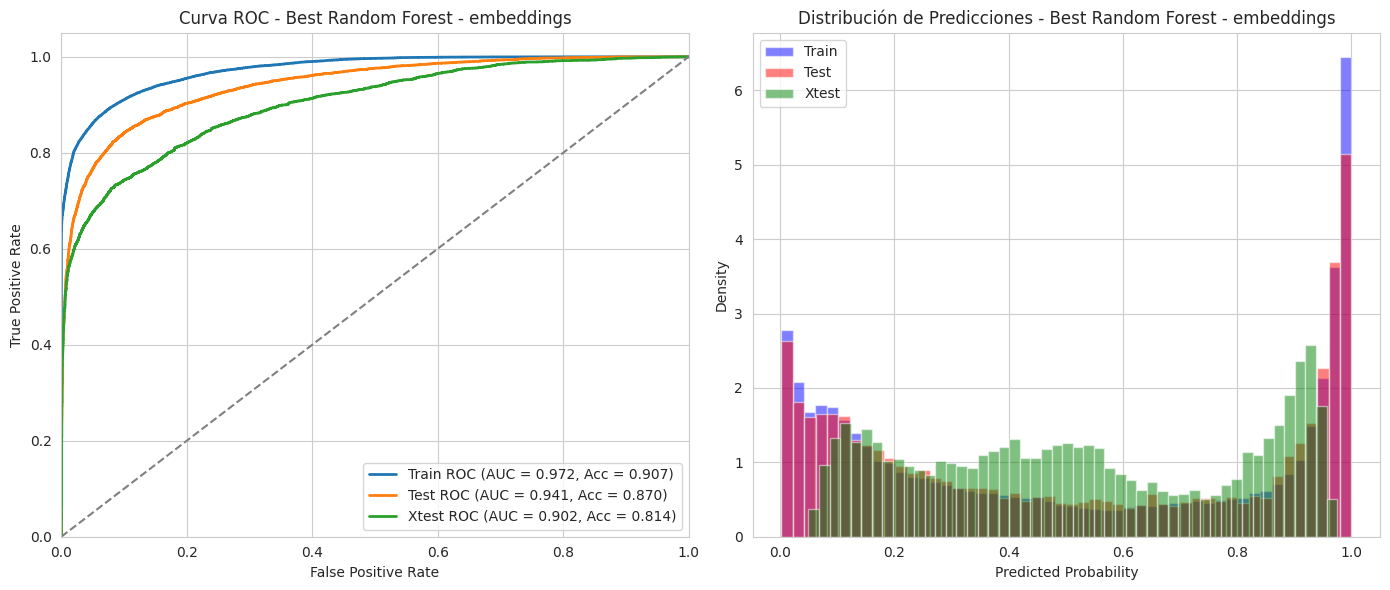

In [178]:
print("Aplicar preprocesamiento")
df_test = Xtest_main[ftest].copy()
Xtest_transformed, ytest, model_rf = preprocess_embedding_model('best_rf', df_test, target, PATH_MODELS)

plot_model_evaluation(y_train, model_rf.predict_proba(X_train_transformed)[:, 1],
                      y_test, model_rf.predict_proba(X_test_transformed)[:, 1],
                      ytest, model_rf.predict_proba(Xtest_transformed)[:, 1],
                      model_name="Best Random Forest - embeddings")

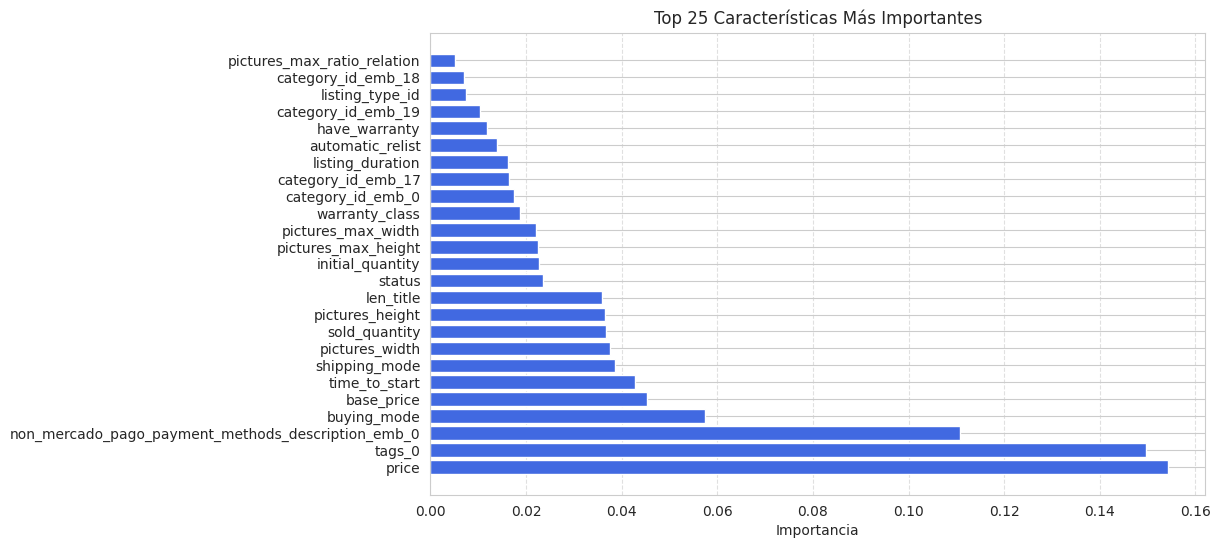

In [179]:
plot_feature_importance(model_rf.feature_importances_, X_train.columns, top_n=25)

### 4.2.1 Embedding encoder + All features + Logistic Regresion + Tuning

In [180]:
ftest = feature + feature_engineering + target # features

In [ ]:
%%time

# Normalizar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-4, 10)  # Regularización
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])  # Tipo de penalización
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'  # Solvers compatibles

    model = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=42, max_iter=1000)

    # Validación cruzada con 5 folds
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="accuracy")

    for step, score in enumerate(scores):
        trial.report(score, step)  # Reportar progreso
        if trial.should_prune():  # Si va mal, detener trial
            raise optuna.exceptions.TrialPruned()

    return scores.mean()  # Maximizar ROC AUC

# Ejecutar Optuna con pruning
study = optuna.create_study(direction='maximize', pruner=MedianPruner())
study.optimize(objective, n_trials=35, callbacks=[early_stopping_callback])

# Mejor conjunto de hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

# Entrenar modelo con los mejores hiperparámetros
best_logreg = LogisticRegression(**best_params, random_state=42, max_iter=1000)
best_logreg.fit(X_train_scaled, y_train)

# Evaluar en test y test2
y_test_pred = best_logreg.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_test_pred)
test_roc = roc_auc_score(y_test, best_logreg.predict_proba(X_test_scaled)[:, 1])

print(f"Test Accuracy: {test_acc:.4f}, ROC AUC: {test_roc:.4f}")

# Guardar modelo y parámetros
joblib.dump(best_logreg, PATH_MODELS / "embedding_encoding_tuning/best_logreg.pkl")
joblib.dump(scaler, PATH_MODELS / "embedding_encoding_tuning/scaler.pkl")  # Guardar scaler
with open(PATH_MODELS / "embedding_encoding_tuning/best_hyperparameters_logreg.json", "w") as f:
    json.dump(best_params, f)

# Graficar la optimización de Optuna
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

print("Modelo, preprocesador y mejores hiperparámetros guardados correctamente.")

[I 2025-02-24 22:13:28,309] A new study created in memory with name: no-name-f59a1e10-e0f3-4eef-a82e-b08dcdbcfbe3
[I 2025-02-24 22:13:47,354] Trial 0 finished with value: 0.8110661505981703 and parameters: {'C': 2.4403469695925475, 'penalty': 'l2'}. Best is trial 0 with value: 0.8110661505981703.
[I 2025-02-24 22:13:49,713] Trial 1 finished with value: 0.7813863476425053 and parameters: {'C': 0.0003802913079848313, 'penalty': 'l2'}. Best is trial 0 with value: 0.8110661505981703.
[I 2025-02-24 22:13:52,448] Trial 2 finished with value: 0.7845707248416608 and parameters: {'C': 0.0008899871531902807, 'penalty': 'l2'}. Best is trial 0 with value: 0.8110661505981703.
[I 2025-02-24 22:14:11,679] Trial 3 finished with value: 0.8102216748768474 and parameters: {'C': 0.9126587476009098, 'penalty': 'l2'}. Best is trial 0 with value: 0.8110661505981703.
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of ite

In [ ]:
x

#### 1 - results

Aplicar preprocesamiento
Modelo best_logreg y preprocesador cargados correctamente.
Preparar datos
Aplicar embedding
Aplicar preprocessor


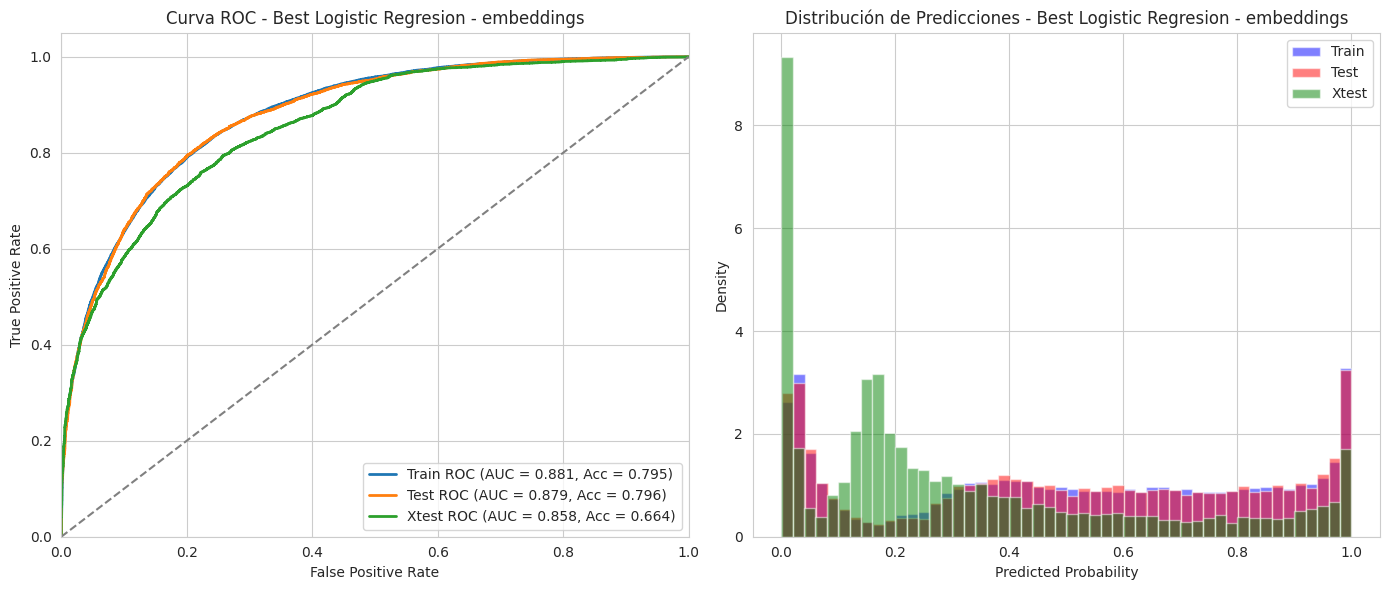

In [191]:
print("Aplicar preprocesamiento")
df_test = Xtest_main[ftest].copy()
Xtest_transformed, ytest, model_lr = preprocess_embedding_model('best_logreg', df_test, target, PATH_MODELS)

plot_model_evaluation(y_train, model_lr.predict_proba(X_train_transformed)[:, 1],
                      y_test, model_lr.predict_proba(X_test_transformed)[:, 1],
                      ytest, model_lr.predict_proba(Xtest_transformed)[:, 1],
                      model_name="Best Logistic Regresion - embeddings")

### 4.3.1 Embedding encoder + All features + Neural Networks + Tuning

In [ ]:
ftest = feature + feature_engineering + target # features

In [193]:
%%time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Función para construir el modelo
def create_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)  # Número de capas ocultas
    neurons = [trial.suggest_int(f"n_units_l{i}", 32, 256) for i in range(n_layers)]
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])

    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_scaled.shape[1],)))

    for n in neurons:
        model.add(layers.Dense(n, activation=activation))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# Función de optimización de Optuna
def objective(trial):
    model = create_model(trial)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_test_scaled, y_test),
                        epochs=50, batch_size=batch_size,
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                        verbose=0)

    val_acc = max(history.history["val_accuracy"])
    return val_acc

# Ejecutar Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=35, callbacks=[early_stopping_callback])

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

# Entrenar modelo final con los mejores hiperparámetros
best_model = create_model(optuna.trial.FixedTrial(best_params))
best_model.fit(X_train_scaled, y_train, epochs=50, batch_size=best_params["batch_size"],
               validation_data=(X_test_scaled, y_test),
               callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
               verbose=1)

# Evaluar modelo final
y_test_pred = (best_model.predict(X_test_scaled) > 0.5).astype("int32")
test_acc = accuracy_score(y_test, y_test_pred)
test_roc = roc_auc_score(y_test, best_model.predict(X_test_scaled))

print(f"Test Accuracy: {test_acc:.4f}, ROC AUC: {test_roc:.4f}")

# Guardar modelo entrenado y preprocesadores
best_model.save(PATH_MODELS / "embedding_encoding_tuning/best_nn.h5")  # Guardar como .h5
with open(PATH_MODELS / "embedding_encoding_tuning/best_hyperparameters_nn.json", "w") as f:
    json.dump(best_params, f)

# Graficar resultados de Optuna
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

print("Modelo, preprocesador y mejores hiperparámetros guardados correctamente.")

[I 2025-02-24 20:24:34,134] A new study created in memory with name: no-name-308becc7-0970-4f64-a6ab-83929cf622a0
[I 2025-02-24 20:31:34,509] Trial 0 finished with value: 0.8428682088851929 and parameters: {'n_layers': 1, 'n_units_l0': 63, 'dropout_rate': 0.25123916268474533, 'learning_rate': 0.0014371565258757745, 'activation': 'relu', 'batch_size': 32}. Best is trial 0 with value: 0.8428682088851929.
[I 2025-02-24 20:36:47,553] Trial 1 finished with value: 0.8301315903663635 and parameters: {'n_layers': 3, 'n_units_l0': 94, 'n_units_l1': 48, 'n_units_l2': 234, 'dropout_rate': 0.3110102718955513, 'learning_rate': 0.0043405424145563426, 'activation': 'relu', 'batch_size': 32}. Best is trial 0 with value: 0.8428682088851929.
[I 2025-02-24 20:41:40,161] Trial 2 finished with value: 0.8487087488174438 and parameters: {'n_layers': 2, 'n_units_l0': 225, 'n_units_l1': 133, 'dropout_rate': 0.19823849080994732, 'learning_rate': 0.0009322167636989698, 'activation': 'tanh', 'batch_size': 64}. Be

Early stopping activado: No hay mejoras en los últimos 5 trials
Mejores hiperparámetros: {'n_layers': 2, 'n_units_l0': 225, 'n_units_l1': 133, 'dropout_rate': 0.19823849080994732, 'learning_rate': 0.0009322167636989698, 'activation': 'tanh', 'batch_size': 64}
Epoch 1/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7735 - loss: 0.4561 - val_accuracy: 0.8094 - val_loss: 0.4066
Epoch 2/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8044 - loss: 0.4112 - val_accuracy: 0.8173 - val_loss: 0.3916
Epoch 3/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8116 - loss: 0.3953 - val_accuracy: 0.8205 - val_loss: 0.3854
Epoch 4/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8185 - loss: 0.3879 - val_accuracy: 0.8258 - val_loss: 0.3786
Epoch 5/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8207 - loss: 0.3812 - val_accuracy: 0.8258 - val_loss: 0.3745
Epoch 6/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8249 - loss: 0.3791 - val_accurac

Test Accuracy: 0.8468, ROC AUC: 0.9289
Modelo, preprocesador y mejores hiperparámetros guardados correctamente.
CPU times: user 46min 5s, sys: 1min 49s, total: 47min 54s
Wall time: 50min 51s


#### 1 - results

Aplicar preprocesamiento
Cargar modelo y preprocesador
Modelo best_nn y preprocesador cargados correctamente.
Preparar datos
Aplicar embedding
Aplicar preprocessor
Aplicar scaler
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
445/445 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


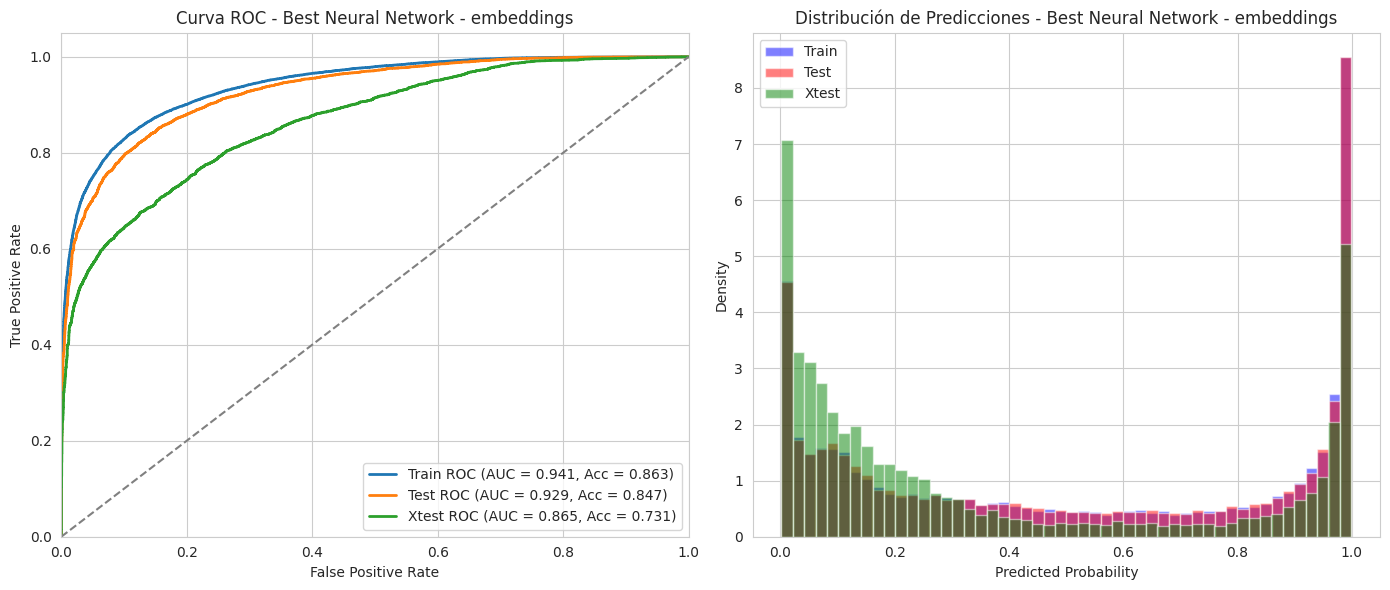

In [213]:
print("Aplicar preprocesamiento")
df_test = Xtest_main[ftest].copy()
Xtest_transformed, ytest, model_nn = preprocess_embedding_model('best_nn', df_test, target, PATH_MODELS)

plot_model_evaluation(
    y_train, (model_nn.predict(X_train_scaled)),
    y_test, (model_nn.predict(X_test_scaled)),
    ytest, (model_nn.predict(Xtest_transformed)),
    model_name="Best Neural Network - embeddings"
)

In [ ]:
df_test = Xtest_main[ftest].copy()
df_test = df_test.astype(conversion_dict)

models_name = ['NeuralNetwork', 'LogisticRegression', 'RandomForest']
result_all_feature = pd.DataFrame()
for model_name in models_name:
    df_resultados = evaluar_modelo(model_name, df_test, target, PATH_MODELS)
    result_all_feature = pd.concat([result_all_feature, df_resultados])
print(result_all_feature)

Modelo NeuralNetwork y preprocesador cargados correctamente.
Preparar datos
Aplicar preprocesamiento
🔍 NeuralNetwork - Accuracy: 0.7673, ROC AUC: 0.8687
Modelo LogisticRegression y preprocesador cargados correctamente.
Preparar datos
Aplicar preprocesamiento
🔍 LogisticRegression - Accuracy: 0.6966, ROC AUC: 0.8689
Modelo RandomForest y preprocesador cargados correctamente.
Preparar datos
Aplicar preprocesamiento
🔍 RandomForest - Accuracy: 0.7954, ROC AUC: 0.8876
               Modelo  Accuracy   ROC AUC
0       NeuralNetwork    0.7673  0.868652
0  LogisticRegression    0.6966  0.868932
0        RandomForest    0.7954  0.887589


### 4.3.4 summary

In [ ]:
df_test = Xtest_main[ftest].copy()
df_test = df_test.astype(conversion_dict)

models_name = ['NeuralNetwork', 'LogisticRegression', 'RandomForest']
result_feature_selec = pd.DataFrame()
for model_name in models_name:
    df_resultados = evaluar_modelo(model_name, df_test, target, PATH_MODELS)
    result_feature_selec = pd.concat([result_feature_selec, df_resultados])
print(result_feature_selec)

# referencias

https://scholarworks.bwise.kr/hanyang/bitstream/2021.sw.hanyang/141386/1/A_Deep-Learned_Embedding_Technique_for_Categorical_Features_Encoding.pdf?utm_source=chatgpt.com

https://arxiv.org/pdf/2403.19405